## Finding the adversarial images

In [1]:
from fitness import fitness as fitness_obj
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from tensorflow import keras
from inner_genetic_algorithm import inner_algorithm
from filters.filters import img_filters
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
class MyProblem(ElementwiseProblem):

    def __init__(self, tf_model):
        n_variables = 5 - 1
        ## since our chromosomes will be permuted, the filter count should be the same as n_variables
        filter_count = n_variables
        super().__init__(
            n_var= n_variables, 
            n_obj=2, 
            n_ieq_constr=0, 
            xl= np.zeros(n_variables), 
            xu=np.full(n_variables, filter_count - 1)
        )
        self.tf_model = tf_model
          

    def _evaluate(self, x, out, *args, **kwargs):
        algorithm = inner_algorithm(self.tf_model, x)
        X_res, F_res = algorithm.start()

        with open('results/filters_with_param_X.txt', 'a+') as file:
            np.savetxt(file, X_res)
            file.write('\n')

        with open('results/filters_with_param_F.txt', 'a+') as file:
            np.savetxt(file, F_res)
            file.write('\n')
        
        out["F"] = F_res[0]


In [3]:
model = keras.models.load_model('model/cifar10_model_90%val_accuracy.h5')
problem = MyProblem(model)

algorithm = NSGA2(
    pop_size=10,
    n_offsprings=10,
    sampling=PermutationRandomSampling(),
    crossover=OrderCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 5)

In [4]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=False,
               verbose=True)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        8 |      4 |             - |             -
     2 |       18 |      4 |  0.1052631579 |         ideal
     3 |       28 |      4 |  0.000000E+00 |             f
     4 |       38 |      4 |  0.000000E+00 |             f
     5 |       48 |      4 |  0.000000E+00 |             f


In [5]:
with open('results/final_results_X.txt', 'w') as file:
    np.savetxt(file, res.X)
with open('results/final_results_F.txt', 'w') as file:
    np.savetxt(file, res.F)


In [6]:
res.X

array([[3, 0, 1, 2],
       [1, 2, 3, 0],
       [1, 2, 0, 3],
       [3, 2, 1, 0]])

In [7]:
res.F

array([[0.65, 0.27],
       [0.34, 0.44],
       [0.35, 0.31],
       [0.68, 0.25]])

In [8]:
## chromosomes
string_X = None
## fitnesses
string_F = None
with open('results/filters_with_param_X.txt', 'r') as file:
    string_X = file.read()

with open('results/filters_with_param_F.txt', 'r') as file:
    string_F = file.read()

In [9]:
chromosomes_filter = np.fromstring(string_X.split('\n')[-3], sep=' ')
chromosome_fitness = np.fromstring(string_F.split('\n')[-3], sep=' ')

In [10]:
def get_filter_function(filter_gene, filter_alpha, filter_strength, verbose=True):
    """
    get the filter function
    """
    ## to choose the filter
    if filter_gene == 0 :
        filter_name = 'kelvin'
    elif filter_gene == 1:
        filter_name = 'clarendon'
    elif filter_gene == 2:
        filter_name = 'moon'
    elif filter_gene == 3:
        filter_name = 'gingham'
    else:
        raise ValueError(f'filter chromosome value should be integer values between 0 to 3, entered value: {filter_gene}')
    
    if verbose: print(f'Filter name: {filter_name}')
    
    filter_function = img_filters(filter_alpha, filter_strength, filter_name )
    return filter_function

def apply_multiple_filters(filter_functions, images_batch):
    """
    apply multiple filters on one image
    filter_functions are the multiple filters function extracted from a chromosome 

    returns the manipulated images (filtered ones)
    """
    ## filtered images are saved in the array
    manipulated_images_arr = []

    ## for images
    for image in images_batch:
        manipulated_image = np.copy(image)

        ## Apply multiple filters to the image
        for filter_func in filter_functions:
            manipulated_image = filter_func.apply(manipulated_image)
        
        manipulated_images_arr.append(manipulated_image)
    ## convert back to numpy array
    manipulated_images_arr = np.array(manipulated_images_arr)
    
    return manipulated_images_arr

In [11]:
## the index of parameters of each filter
parameter_index = {
    0: [4, 5],
    1: [6, 7],
    2: [8, 9],
    3: [10, 11],
    # 4: [13, 14]
}

functions_arr = []
for i in range(4):
    filter_gene = chromosomes_filter[i]
    filter_alpha_gene = chromosomes_filter[parameter_index[i][0]]
    filter_strength_gene = chromosomes_filter[parameter_index[i][1]]

    filter_function = get_filter_function(filter_gene, filter_alpha_gene, filter_strength_gene)
    functions_arr.append(filter_function)

Filter name: moon
Filter name: gingham
Filter name: clarendon
Filter name: kelvin


In [12]:
(x_train, _), (_, _) = keras.datasets.cifar10.load_data()

In [21]:
images_manipulated = apply_multiple_filters(functions_arr, x_train[:50])

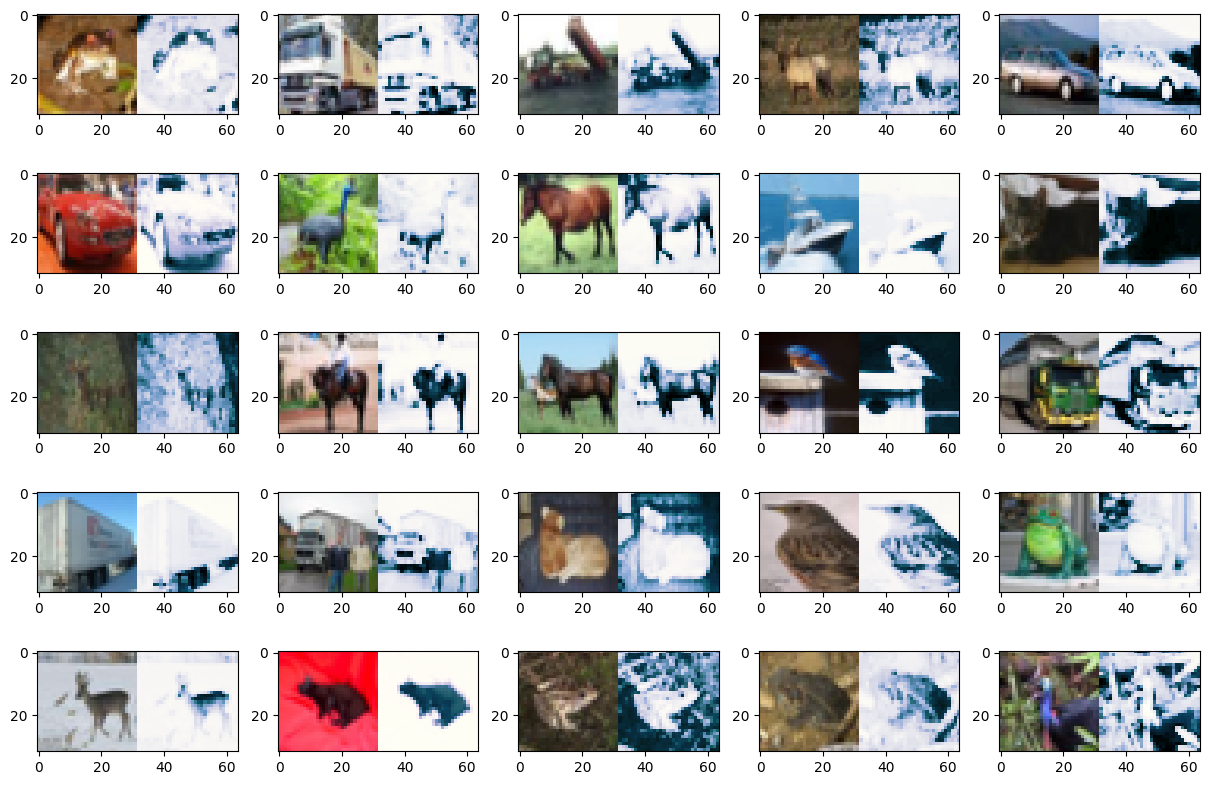

In [22]:
# index_image = 2
n_rows = 5
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i in range(n_rows):
    for j in range(n_cols):
        ## append the original image to the manipulated one
        image = np.append(x_train[i * n_cols+j] ,images_manipulated[i * n_cols+j], axis=1)
        ax[i][j].imshow(image)
plt.show()

## Filters parameters effect
In this section we're going to see the effect of different filter parameters on images individually. 

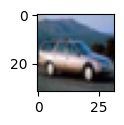

In [15]:
## first use an image as baseline
plt.figure(figsize=(1, 1))
image = x_train[4]
plt.imshow(image)
plt.show()

In [16]:
filters_arr = [0, 1, 2, 3]
alphas_arr = np.linspace(0, 1, 11)

In [17]:
## initialize with black images
# whole_img = np.zeros((384, 32, 3))
whole_img = np.zeros(((len(alphas_arr) + 1) * image.shape[0], image.shape[1], image.shape[2]))


for filter_idx in filters_arr:
    ## kelvin filter
    filtered_img = image
    for alpha_value in alphas_arr:
        # print(filter_idx, alpha_value)
        filter = get_filter_function(filter_idx, alpha_value, filter_strength=1, verbose=False)
        manipulated_img = filter.apply(image)

        filtered_img = np.append(filtered_img, manipulated_img, axis=0)
    whole_img = np.append(whole_img, filtered_img, axis=1)

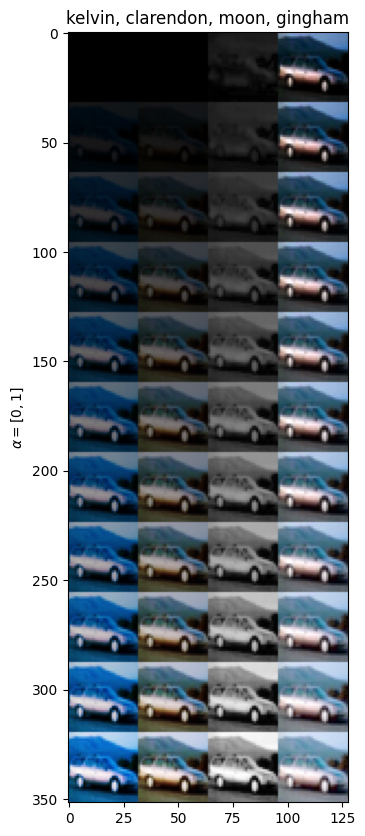

In [18]:
f, ax = plt.subplots(figsize=(7, 10))
ax.set_title('kelvin, clarendon, moon, gingham')
## the 32 first column is just black images
ax.imshow(whole_img[32:, 32:] / 255)
ax.set_ylabel('$\\alpha=[0, 1]$')

plt.show()

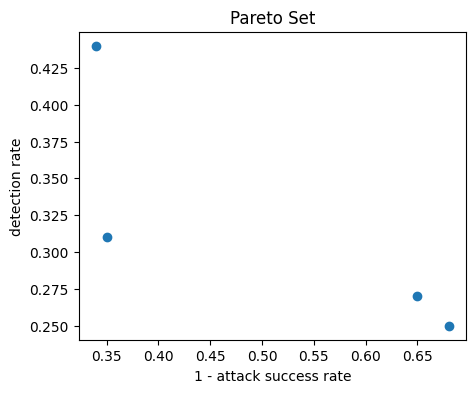

In [19]:
plt.figure(figsize=(5,4))
plt.title('Pareto Set')
plt.scatter(res.F[:, 0], res.F[:, 1])
plt.xlabel('1 - attack success rate')
plt.ylabel('detection rate')
plt.show()